# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [28]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int32(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [29]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
    Sy = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1]).reshape((3,3))
    nG = np.sqrt(convolve2d(I, Sx, mode='same')**2 + convolve2d(I, Sy, mode='same')**2)
    return np.where(nG > s, 255, 0)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [30]:
def zero_crossing(IL, s):
    ILp = np.pad(IL, 1)
    IL_ = IL.copy()
    for i in range(IL.shape[0]):
        for j in range(IL.shape[1]):
            sub = ILp[i:i+3,j:j+3]
            maxSub = np.max(sub)
            minSub = np.min(sub)
            if (maxSub > 0) and (minSub < 0) and (maxSub - minSub > s):
                IL_[i,j] = 255
            else:
                IL_[i,j] = 0
    return IL_

def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([0,1,0,1,-4,1,0,1,0]).reshape((3,3))
    IL = convolve2d(I, L, mode='same')
    return zero_crossing(IL, s)


3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

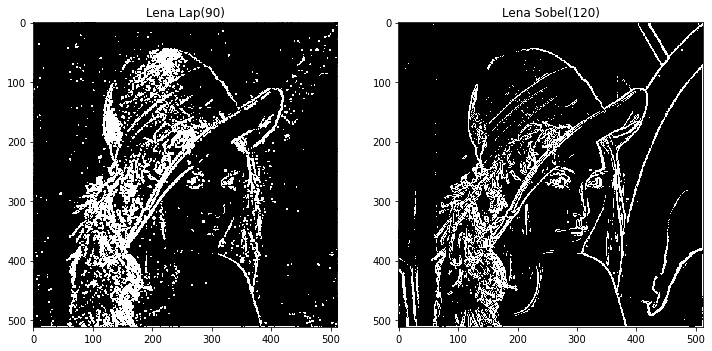

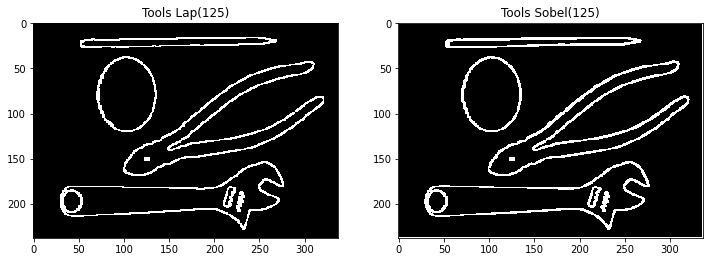

In [31]:
tools = np.array(Image.open('img/tools.png'))
lena = np.array(Image.open('img/lena.png'))
niceDisplay14([LaplacianDetector(lena, 90), SobelDetector(lena, 120)], ['Lena Lap(90)', 'Lena Sobel(120)'])
niceDisplay14([LaplacianDetector(tools, 125), SobelDetector(tools, 125)], ['Tools Lap(125)', 'Tools Sobel(125)'])

In [32]:
threshold = np.arange(10,400,20)
diff = []
for i in threshold:
    so = SobelDetector(lena, i)
    lp = LaplacianDetector(lena, i)
    diff.append(np.mean(np.abs(lp-so)))

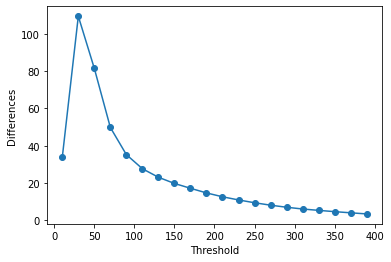

In [33]:
plt.plot(threshold, diff)
plt.scatter(threshold, diff)
plt.xlabel("Threshold")
plt.ylabel("Differences")
plt.show()

On remarque que plus la valeur du seuil augmente, plus la différence entre la détection des contours des deux détecteur diminue.

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

In [34]:
%matplotlib notebook
#### your answer below
Sx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
Sy = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1]).reshape((3,3))

I = tools
Ix = convolve2d(I, Sx, mode='same')
Iy = convolve2d(I, Sy, mode='same')
Ig = np.sqrt(Ix**2 + Iy**2)
imshow_hot(orientation(Ix, Iy, Ig))

<IPython.core.display.Javascript object>

Explain the different values given to a pixel by `orientation()`:

Your answer: Image des orientations selon direction gradient valeur attribuée...
Selon la direction du gradient, une valeur a été attribué à chaque pixel de la même direction :
- Et les pixels noirs --> 0 --> orientatoin de 0
- Les pixels rouges --> 1 --> orientation de $\pi/2$
- Les pixels oranges --> 2 --> orientation de $\pi/4$
- Les pixels jaunes --> 3 --> orientation de $\pi$
- Les pixels blanc --> 4 --> orientation de $3\pi/4$

On remarque que l'attribution des valeurs et de couleurs est en fonction de l'orientation.


2. Write a function `nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [35]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    Inms = np.zeros(Ig.shape)
    Ig_ = np.pad(Ig, 1)
    for i in range(Ig.shape[0]-2):
        for j in range(Ig.shape[1]-2):
            ori = Ior[i,j]
            norm = Ig_[i+1,j+1]
            if(norm > 0):
                if(ori == 1):
                    if(norm >= max(Ig_[i-1,j],Ig_[i+1,j])):
                        Inms[i,j] = 255
                elif(ori == 2):
                    if(norm >= max(Ig_[i-1,j-1],Ig_[i+1,j+1])):
                        Inms[i,j] = 255
                elif(ori == 3):
                    if(norm >= max(Ig_[i,j-1],Ig_[i,j+1])):
                        Inms[i,j] = 255
                elif(ori == 4):
                    if(norm >= max(Ig_[i-1,j+1],Ig_[i+1,j-1])):
                        Inms[i,j] = 255
    return Inms

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


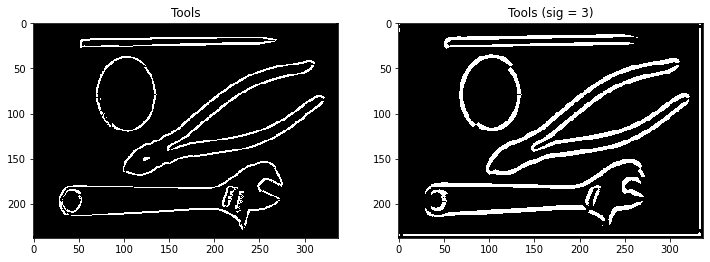

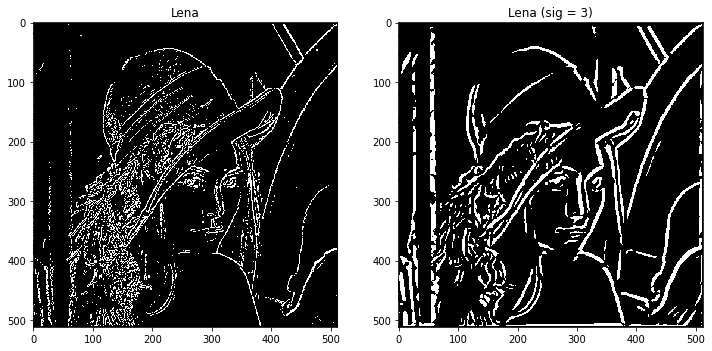

In [36]:
%matplotlib inline
### your answer below
sigma = 3

Itx = convolve2d(tools, Sx, mode='same')
Ity = convolve2d(tools, Sy, mode='same')
Itg = np.sqrt(Itx**2 + Ity**2)
Itnms1 = nms(Itg, orientation(Itx, Ity, Itg))

toolsG = convolve2d(tools, gaussianKernel(sigma), mode='same')
Itx = convolve2d(toolsG, Sx, mode='same')
Ity = convolve2d(toolsG, Sy, mode='same')
Itg = np.sqrt(Itx**2 + Ity**2)
Itg = np.where(Itg > 100, Itg, 0)
Itnms2 = nms(Itg, orientation(Itx, Ity, Itg))

Ilx = convolve2d(lena, Sx, mode='same')
Ily = convolve2d(lena, Sy, mode='same')
Ilg = np.sqrt(Ilx**2 + Ily**2)
Ilg = np.where(Ilg > 100, Ilg, 0)
Ilnms1 = nms(Ilg, orientation(Ilx, Ily, Ilg))

lenaG = convolve2d(lena, gaussianKernel(sigma), mode='same')
Ilx = convolve2d(lenaG, Sx, mode='same')
Ily = convolve2d(lenaG, Sy, mode='same')
Ilg = np.sqrt(Ilx**2 + Ily**2)
Ilg = np.where(Ilg > 30, Ilg, 0)
Ilnms2 = nms(Ilg, orientation(Ilx, Ily, Ilg))

niceDisplay14([Itnms1, Itnms2], ['Tools', 'Tools (sig = 3)'])
niceDisplay14([Ilnms1, Ilnms2], ['Lena', 'Lena (sig = 3)'])

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Plus la valeur de $\sigma$ augmente, plus les contours seront epais. Ceci vient du fait que gaussianKernel rend l'image floue. Ceci permet ainsi d'avoir des contours globaux plus net lors de l'étude des images, à l'inverse les petits détails des contours seront moins bien représentés.

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

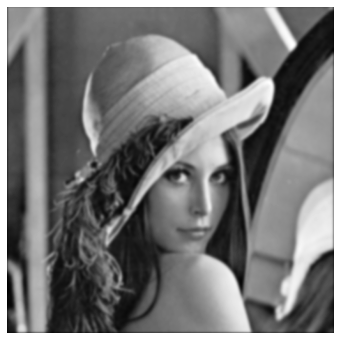

In [37]:
G2 = gaussianKernel(2)
lenaG2 = convolve2d(lena, G2, mode='same')
imshow(lenaG2)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

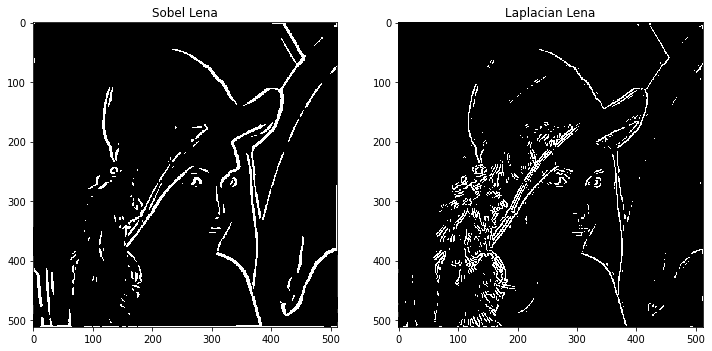

In [38]:
lenaG2Sobel = SobelDetector(lenaG2, 110)
lenaG2Lap = LaplacianDetector(lenaG2, 7)
niceDisplay14([lenaG2Sobel, lenaG2Lap], ['Sobel Lena', 'Laplacian Lena'])

# Sobel ne detecte plus les contours plus détaillés comme les cheveux.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

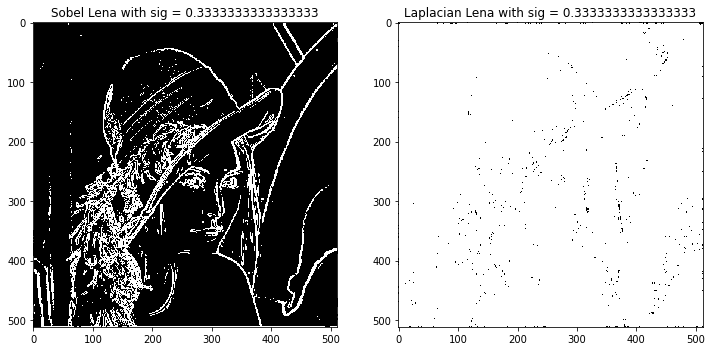

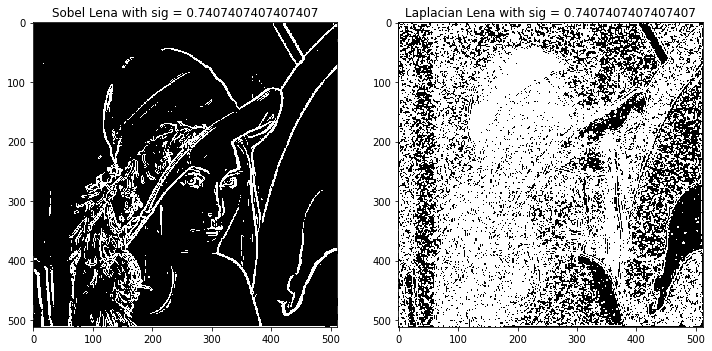

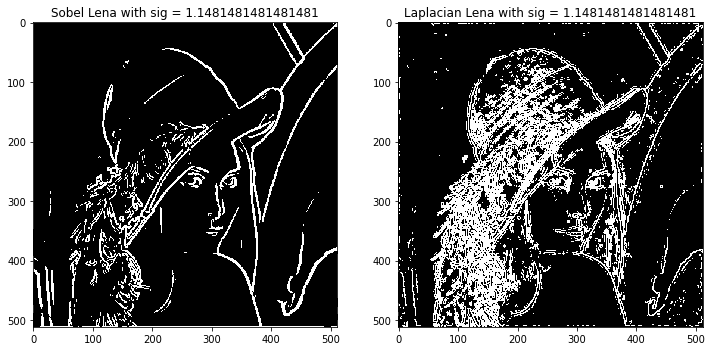

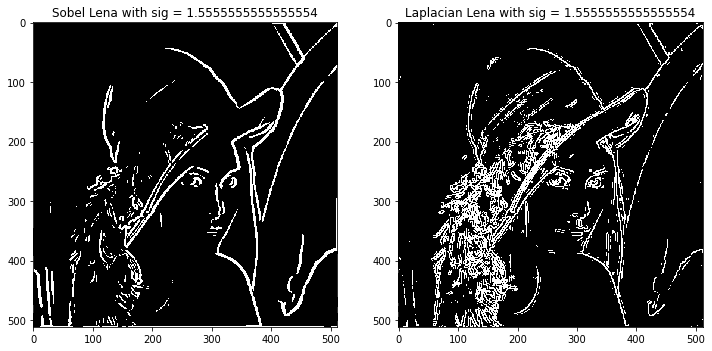

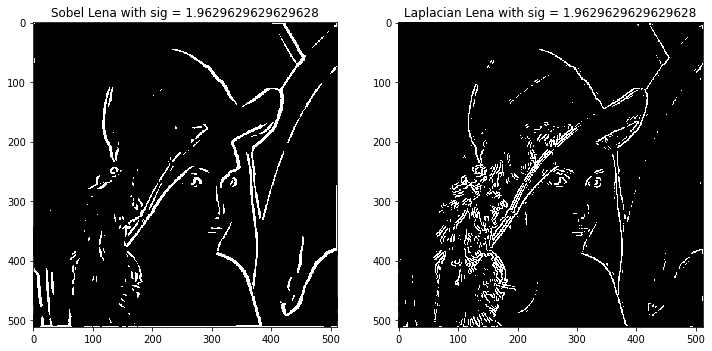

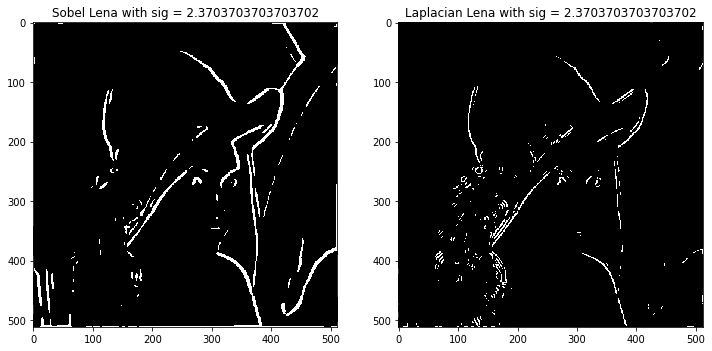

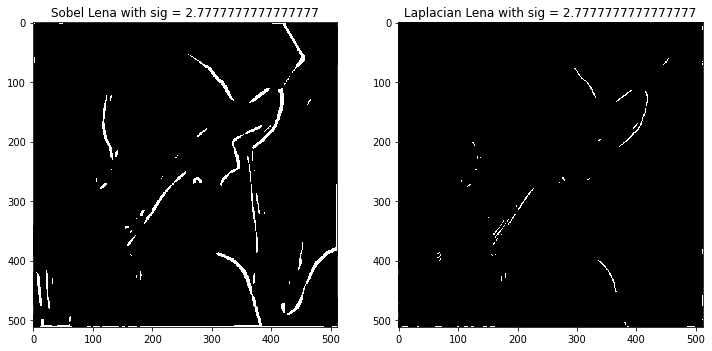

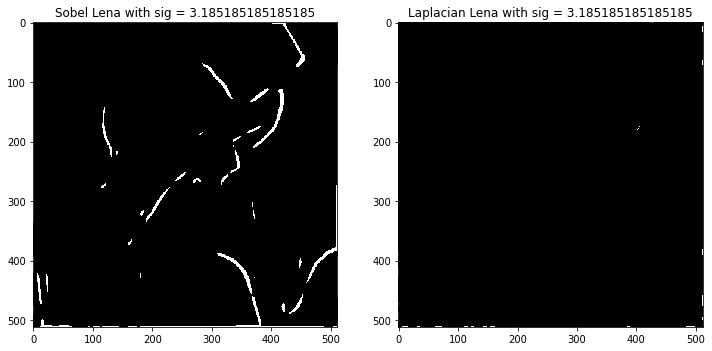

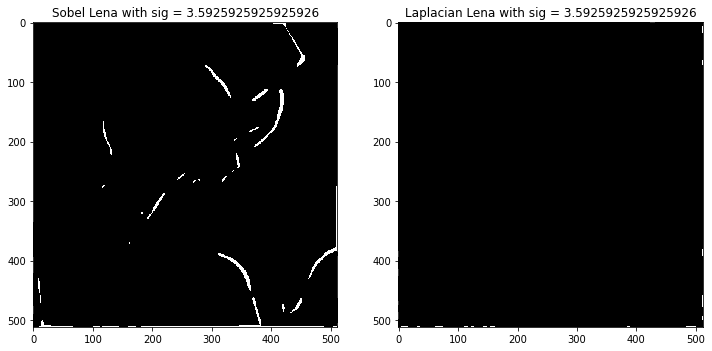

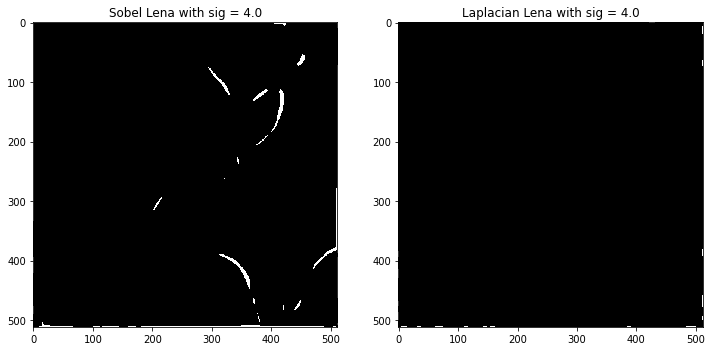

In [39]:
sigr = np.linspace(1/3,4,10)
for sig in sigr:
    GSig = gaussianKernel(sig)
    lenaGsig = convolve2d(lena, GSig, mode='same')
    niceDisplay14([SobelDetector(lenaGsig, 110), LaplacianDetector(lenaGsig, 7)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

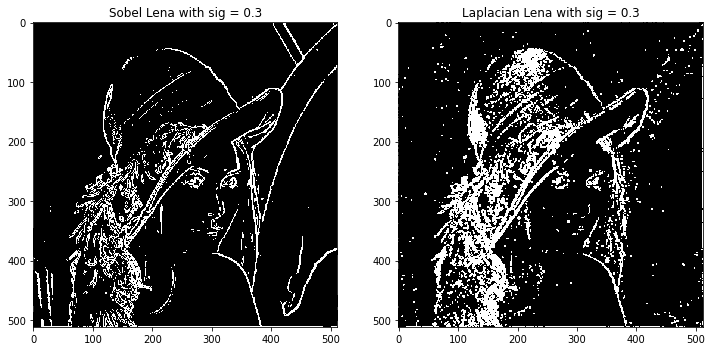

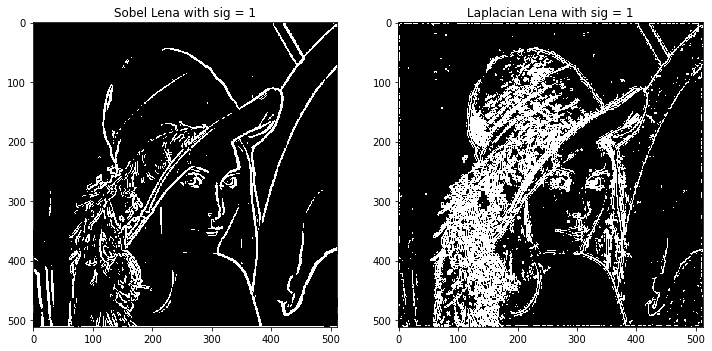

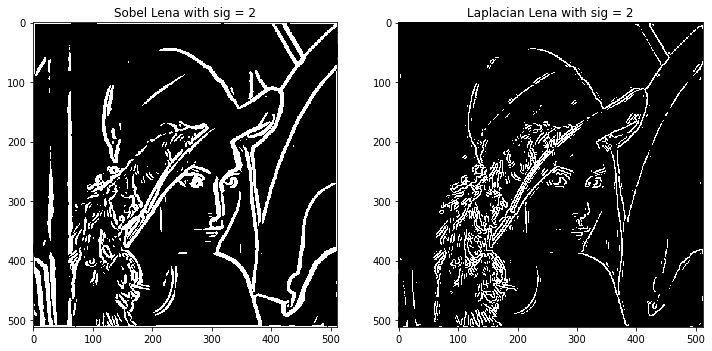

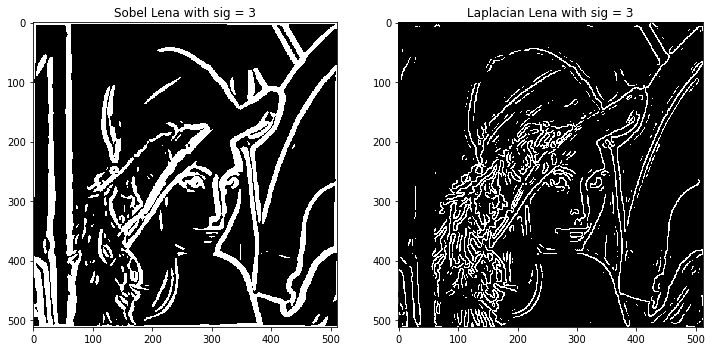

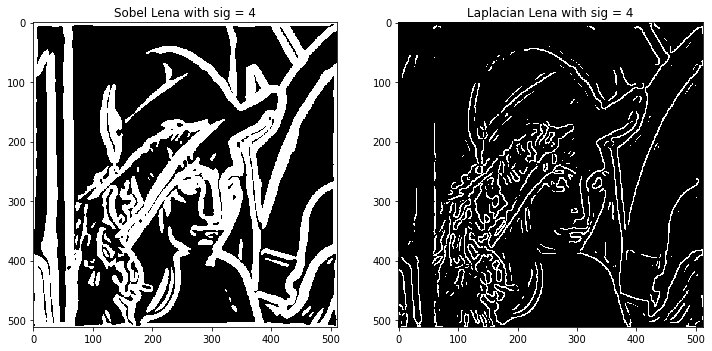

In [40]:
sig = 0.3
Gsig = gaussianKernel(sig)
lenaGsig = convolve2d(lena, Gsig, mode='same')
niceDisplay14([SobelDetector(lenaGsig, 150), LaplacianDetector(lenaGsig, 90)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

sig = 1
Gsig = gaussianKernel(sig)
lenaGsig = convolve2d(lena, Gsig, mode='same')
niceDisplay14([SobelDetector(lenaGsig, 110), LaplacianDetector(lenaGsig, 10)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

sig = 2
Gsig = gaussianKernel(sig)
lenaGsig = convolve2d(lena, Gsig, mode='same')
niceDisplay14([SobelDetector(lenaGsig, 60), LaplacianDetector(lenaGsig, 5)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

sig = 3
Gsig = gaussianKernel(sig)
lenaGsig = convolve2d(lena, Gsig, mode='same')
niceDisplay14([SobelDetector(lenaGsig, 40), LaplacianDetector(lenaGsig, 1)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

sig = 4
Gsig = gaussianKernel(sig)
lenaGsig = convolve2d(lena, Gsig, mode='same')
niceDisplay14([SobelDetector(lenaGsig, 20), LaplacianDetector(lenaGsig, 0.5)], ['Sobel Lena with sig = '+str(sig), 'Laplacian Lena with sig = '+ str(sig)])

Dans les deux cas, l'augmentation de $\sigma$ influe sur l'épaisseur des traits des contours et sur leur localisation. À savoir, avec l'augmentation de $\sigma$ on améliore la netteté des contours ainsi que leur épaisseur mais on perd naturellement en détails (un des avantages est qu'on a alors des contours quasi-continus). Finalement, le plus intéressant reste de faire augmenter $\sigma$ en baissant les valeurs de thresholding, en jouant avec ces deux variables on peut arriver à des contours plus intéressants selon nos besoins.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

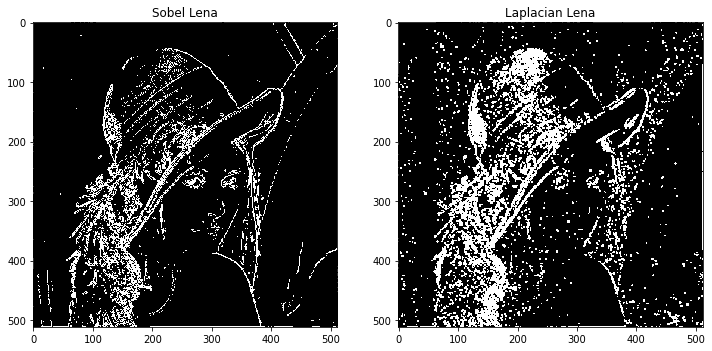

In [41]:
CEF = np.array([0,-1,0,-1,5,-1,0,-1,0]).reshape((3,3))
lenaCEF = convolve2d(lena, CEF, mode='same')
niceDisplay14([SobelDetector(lenaCEF, 300), LaplacianDetector(lenaCEF, 500)], ['Sobel Lena', 'Laplacian Lena'])

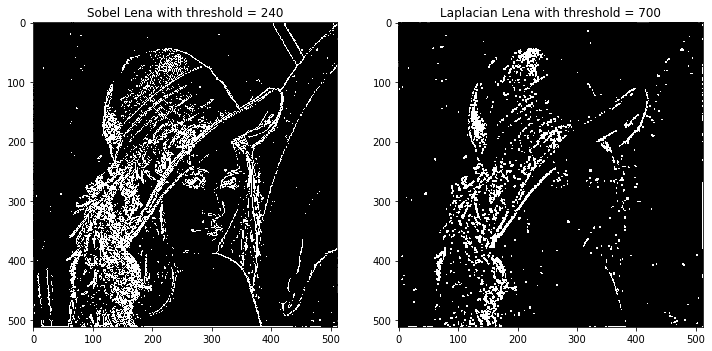

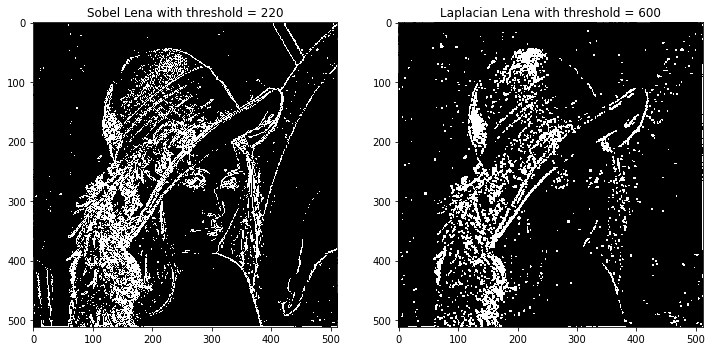

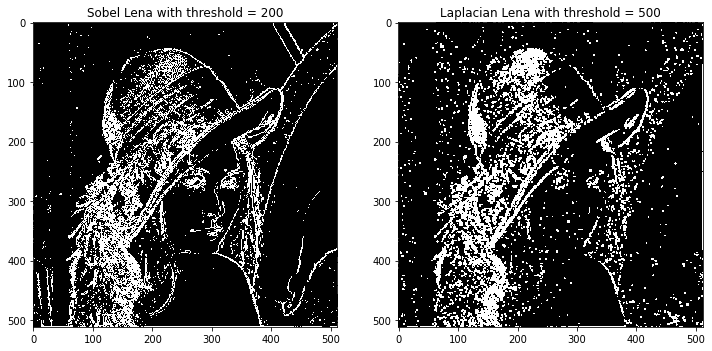

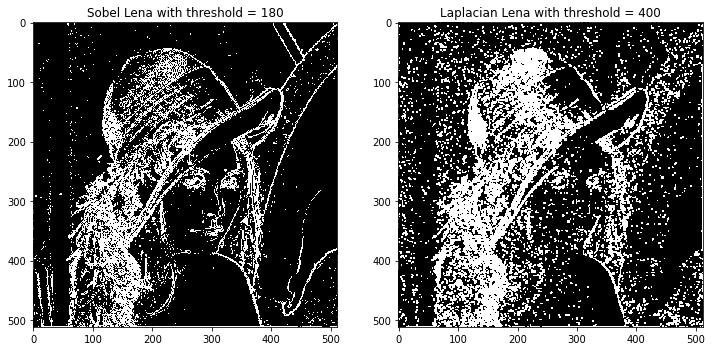

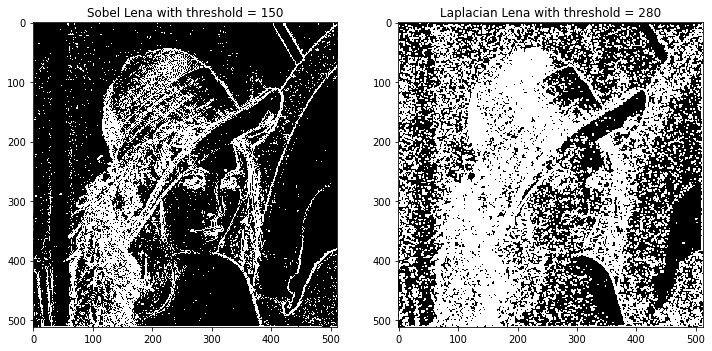

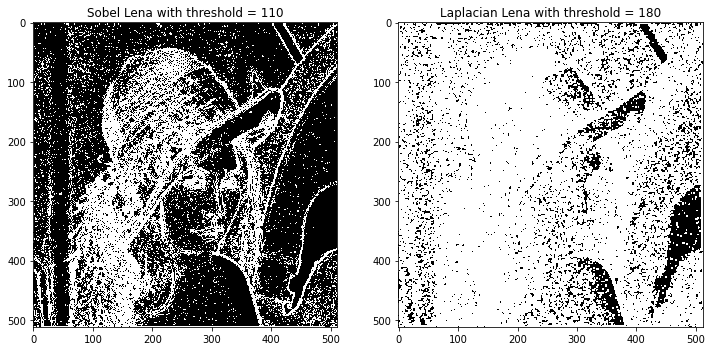

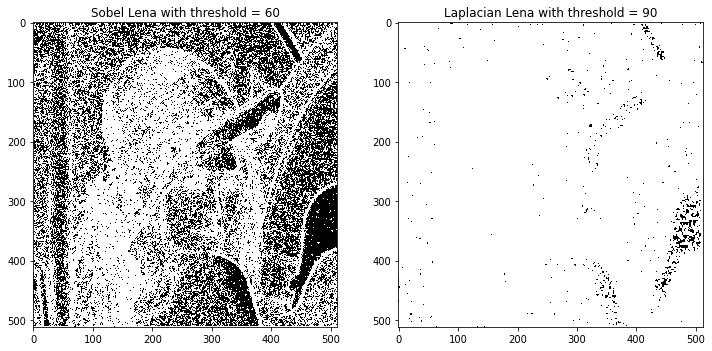

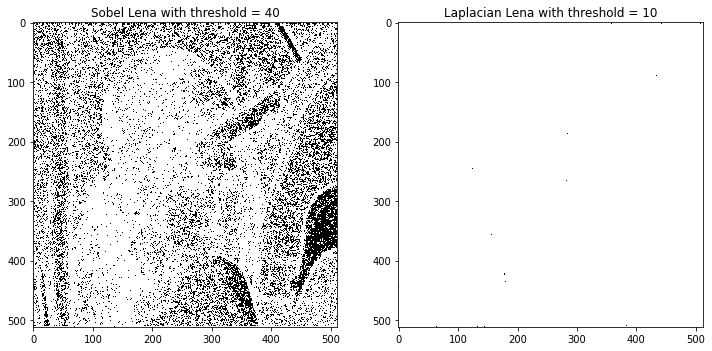

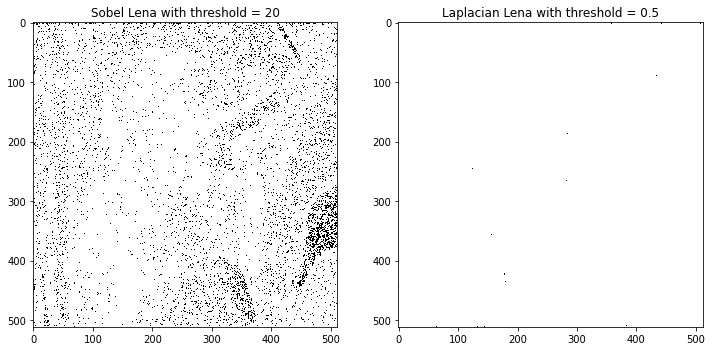

In [42]:
CEF = np.array([0,-1,0,-1,5,-1,0,-1,0]).reshape((3,3))
lenaCEF = convolve2d(lena, CEF, mode='same')

niceDisplay14([SobelDetector(lenaCEF, 240), LaplacianDetector(lenaCEF, 700)], ['Sobel Lena with threshold = 240', 'Laplacian Lena with threshold = 700'])
niceDisplay14([SobelDetector(lenaCEF, 220), LaplacianDetector(lenaCEF, 600)], ['Sobel Lena with threshold = 220', 'Laplacian Lena with threshold = 600'])
niceDisplay14([SobelDetector(lenaCEF, 200), LaplacianDetector(lenaCEF, 500)], ['Sobel Lena with threshold = 200', 'Laplacian Lena with threshold = 500'])
niceDisplay14([SobelDetector(lenaCEF, 180), LaplacianDetector(lenaCEF, 400)], ['Sobel Lena with threshold = 180', 'Laplacian Lena with threshold = 400'])
niceDisplay14([SobelDetector(lenaCEF, 150), LaplacianDetector(lenaCEF, 280)], ['Sobel Lena with threshold = 150', 'Laplacian Lena with threshold = 280'])
niceDisplay14([SobelDetector(lenaCEF, 110), LaplacianDetector(lenaCEF, 180)], ['Sobel Lena with threshold = 110', 'Laplacian Lena with threshold = 180'])
niceDisplay14([SobelDetector(lenaCEF, 60), LaplacianDetector(lenaCEF, 90)], ['Sobel Lena with threshold = 60', 'Laplacian Lena with threshold = 90'])
niceDisplay14([SobelDetector(lenaCEF, 40), LaplacianDetector(lenaCEF, 10)], ['Sobel Lena with threshold = 40', 'Laplacian Lena with threshold = 10'])
niceDisplay14([SobelDetector(lenaCEF, 20), LaplacianDetector(lenaCEF, 0.5)], ['Sobel Lena with threshold = 20', 'Laplacian Lena with threshold = 0.5'])

Avec le filtre CEF, le détecteur Sobel nous renvoie les contours très détaillés avec une valeur du seuil grande (au dessus de 150 environ), et les résultats après cette valeur 150 sont similaires (ce qui est normale, car la matrice après l'application du filtre contiennent des valeurs aux alentours de 130-140), et en dessous de cette valeur, le résultat de la détection est médiocre.

Pour le détecteur Laplacian, il détecte assez bien les contours que si la valeur du seuil est très grande (400-500, voir plus), donc la matrice après l'application du filtre doit avoir des valeurs écartées (c'est-à-dire que la différence entre les min et max est grande). C'est pourquoi avec une valeur de seuil petite, on a que du blanc.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

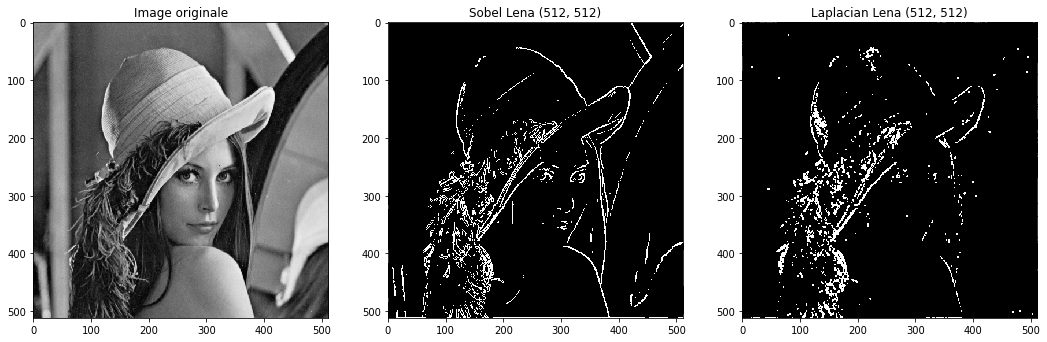

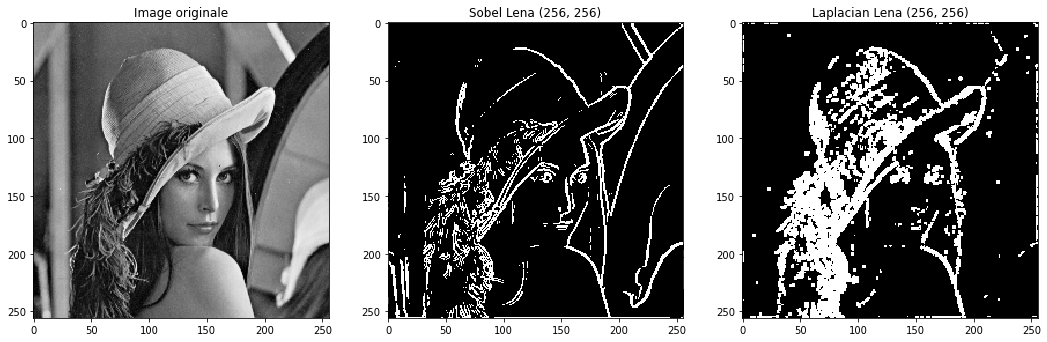

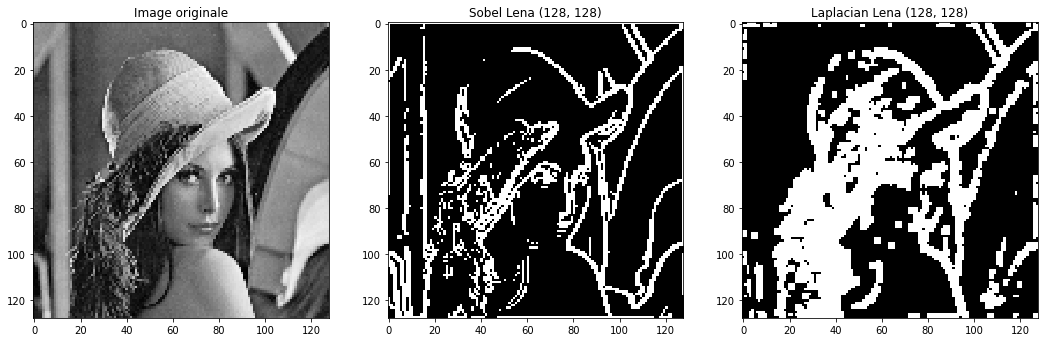

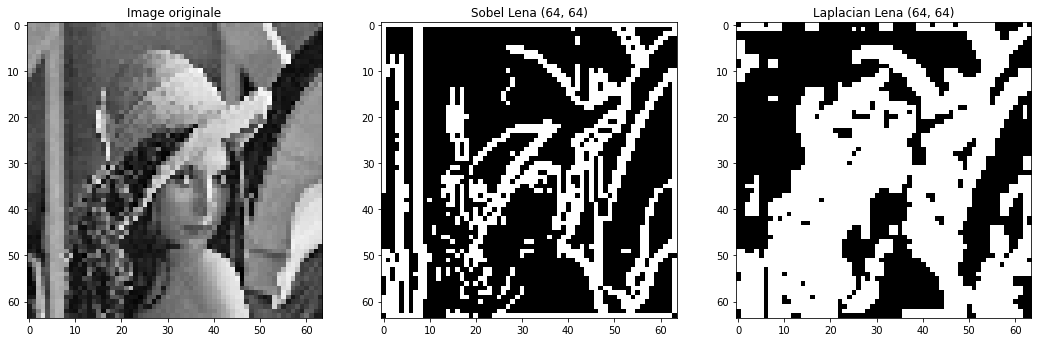

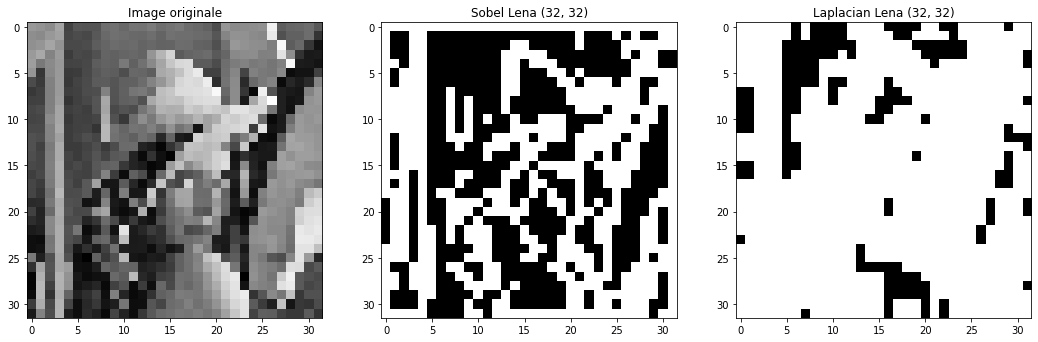

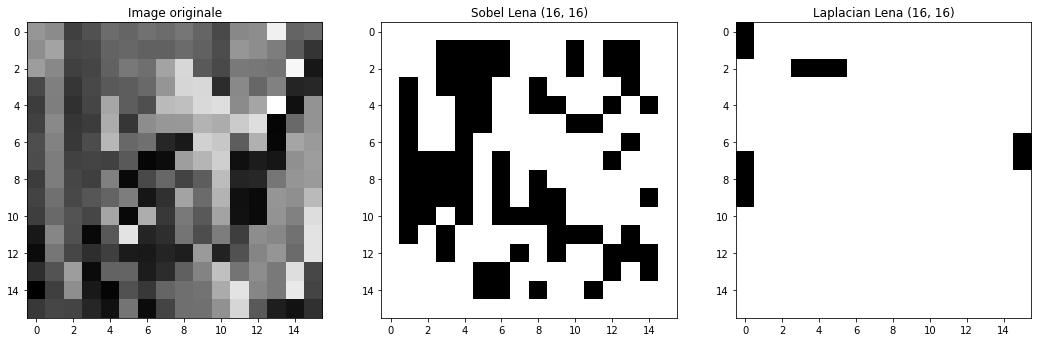

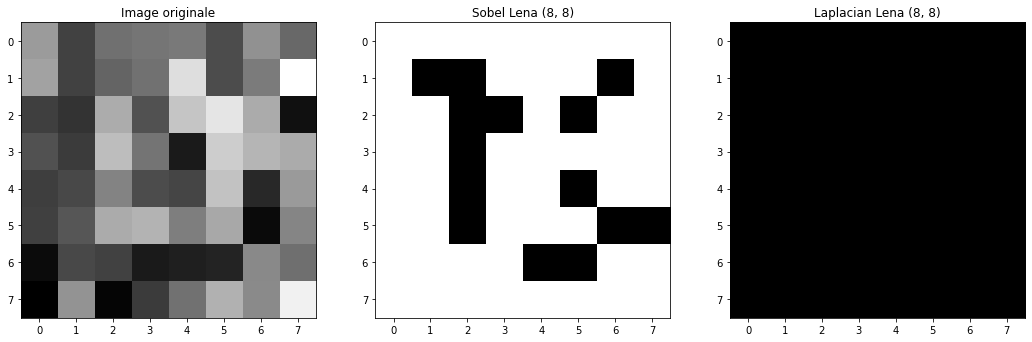

In [43]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

I = lena
for i in range(np.int32(np.log2(I.shape[0])) - 2):
    niceDisplay14([I, SobelDetector(I, 200), LaplacianDetector(I, 150)], ['Image originale', 'Sobel Lena ' + str(I.shape), 'Laplacian Lena ' + str(I.shape)])
    I = subSample2(I)

Plus l'image a de pixels, plus la détection est facile, mais plus le temps est long (le temps dépensé pour chercher les contours). Et avec une image de taille 128*128, les deux détecteurs donnent un résultat où on arrive bien à reconnaître l'image originale, mais avec une image 64*64, le détecteur Laplacian ne renvoie plus un résultat assez reconnaissable alors que Sobel renvoie un résultat assez satisfaisant (on reconnaît à peu près le visage de Lena). Mais en dessous, la détection semble être trop compliquée, même à l'oeil nu, on arrive seulement à reconnaître qu'il y a une personne sur l'image 32*32 à la limite.